In [27]:
import requests
import json
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



In [28]:
should_download_data = False

# Get Games
Fetch games and their id's for multiple months to collect data

In [29]:
# Set common variables
api_key = os.environ['SPORTRADAR_API_KEY']
access_level = 'trial'
version = 'v8'
language_code = 'en'
season_year = '2022'

In [30]:
if should_download_data:
    season_schedule = f"https://api.sportradar.com/nba/{access_level}/{version}/{language_code}/games/{season_year}/REG/schedule.json?api_key={api_key}"
    response = requests.get(season_schedule)
    if response.status_code == 200:
        try:
            schedule_data = response.json()
        except ValueError as e:
            print("Error decoding JSON:", e)
    else:
        print("Failed to retrieve data: ", response.status_code)
    schedule_data = response.json()
    print(json.dumps(schedule_data, indent=4, sort_keys=True))

In [31]:
if should_download_data: 
    with (open("data/season_schedule.json", "w")) as f:
        json.dump(schedule_data, f, indent=4)

In [32]:
# Open the file
with open("data/season_schedule.json", "r") as f:
    schedule_data = json.load(f)

flat_data = schedule_data['games']

df = pd.DataFrame(flat_data)
df["target"] = df["home_points"] > df["away_points"]
df.head()

,id,status,coverage,scheduled,home_points,away_points,track_on_court,sr_id,reference,time_zones,venue,broadcasts,home,away,title,neutral_site,target
0,9f01b268-29c5-4f0e-bf67-21e3dbcf3005,closed,full,2022-10-18T23:30:00Z,126.0,117.0,True,sr:match:35431579,0022200001,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'id': '7d69b080-91ca-53c9-9302-45c1a72c5549',...","[{'network': 'TNT', 'type': 'TV', 'locale': 'N...","{'name': 'Boston Celtics', 'alias': 'BOS', 'id...","{'name': 'Philadelphia 76ers', 'alias': 'PHI',...",NaN,NaN,True
1,c665e441-9f38-48a7-8796-1f7292f97db1,closed,full,2022-10-19T02:00:00Z,123.0,109.0,True,sr:match:35431587,0022200002,"{'venue': 'US/Pacific', 'home': 'US/Pacific', ...","{'id': '938016dc-9e1d-4abc-88f5-3a7d772332e6',...","[{'network': 'TNT', 'type': 'TV', 'locale': 'N...","{'name': 'Golden State Warriors', 'alias': 'GS...","{'name': 'Los Angeles Lakers', 'alias': 'LAL',...",NaN,NaN,True
2,1f8105fe-e6ca-475f-aea6-15b455892a9e,closed,full,2022-10-19T23:00:00Z,107.0,114.0,True,sr:match:35431591,0022200004,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'id': '24bb478e-eb31-5f8a-8c8d-07f513169ec1',...","[{'network': 'NBCS-DC', 'type': 'TV', 'locale'...","{'name': 'Indiana Pacers', 'alias': 'IND', 'id...","{'name': 'Washington Wizards', 'alias': 'WAS',...",NaN,NaN,False
3,9f64a3b0-46bd-4caa-b5c3-4578e9bab8d8,closed,full,2022-10-19T23:00:00Z,113.0,109.0,True,sr:match:35431589,0022200003,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'id': '5a9ddefc-2267-4fd1-8d6e-0f82163ce8bd',...","[{'network': 'BSDET', 'type': 'TV', 'locale': ...","{'name': 'Detroit Pistons', 'alias': 'DET', 'i...","{'name': 'Orlando Magic', 'alias': 'ORL', 'id'...",NaN,NaN,True
4,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,closed,full,2022-10-19T23:30:00Z,108.0,105.0,True,sr:match:35431599,0022200008,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'id': '62cc9661-7b13-56e7-bf4a-bba7ad7be8da',...","[{'network': 'BSOH', 'type': 'TV', 'locale': '...","{'name': 'Toronto Raptors', 'alias': 'TOR', 'i...","{'name': 'Cleveland Cavaliers', 'alias': 'CLE'...",NaN,NaN,True


In [33]:
if should_download_data:

    from concurrent.futures import ThreadPoolExecutor, as_completed
    from tqdm import tqdm

    def get_play_by_play(game_id):
        url = f"https://api.sportradar.com/nba/{access_level}/{version}/{language_code}/games/{game_id}/pbp.json?api_key={api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            try:
                return response.json()
            except ValueError as e:
                print("Error decoding JSON:", e)
        else:
            print("Failed to retrieve data: ", response.status_code)
        return None

    game_ids = [game['id'] for game in schedule_data['games']]

    play_by_play_data = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_game_id = {executor.submit(get_play_by_play, game_id): game_id for game_id in game_ids}
        for future in tqdm(as_completed(future_to_game_id), total=len(game_ids)):
            data = future.result()
            if data is not None:
                play_by_play_data.append(data)

    with open("data/play_by_play_data.json", "w") as f:
        json.dump(play_by_play_data, f, indent=4)

In [34]:
# Get data from the json file and put it into a dataframe

with open('data/play_by_play_data.json') as f:
    data = json.load(f)


In [35]:
# Remove duplicates from data
# TODO: Run the data download again, and remove this line

game_level_data_copy = df.copy()

df = pd.DataFrame(data)
df.head()

,id,status,coverage,scheduled,duration,attendance,lead_changes,times_tied,clock,quarter,...,entry_mode,sr_id,clock_decimal,time_zones,home,away,periods,deleted_events,title,neutral_site
0,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,closed,full,2022-10-19T23:30:00+00:00,2:19,19800.0,16.0,17.0,00:00,4.0,...,WEBSOCKET,sr:match:35431599,00:00,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'name': 'Raptors', 'alias': 'TOR', 'market': ...","{'name': 'Cavaliers', 'alias': 'CLE', 'market'...","[{'type': 'quarter', 'id': '08bea6a0-f82a-41a9...",[{'id': '16d692db-a7a7-43fc-9535-a3187cd349ab'...,NaN,NaN
1,9f01b268-29c5-4f0e-bf67-21e3dbcf3005,closed,full,2022-10-18T23:30:00+00:00,2:31,19156.0,8.0,7.0,00:00,4.0,...,WEBSOCKET,sr:match:35431579,00:00,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'name': 'Celtics', 'alias': 'BOS', 'market': ...","{'name': '76ers', 'alias': 'PHI', 'market': 'P...","[{'type': 'quarter', 'id': 'b2055122-2475-4178...",[{'id': '3a7522fd-dd18-4644-aa0f-fb8294b65c84'...,NaN,NaN
2,9f64a3b0-46bd-4caa-b5c3-4578e9bab8d8,closed,full,2022-10-19T23:00:00+00:00,2:16,20190.0,7.0,4.0,00:00,4.0,...,WEBSOCKET,sr:match:35431589,00:00,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'name': 'Pistons', 'alias': 'DET', 'market': ...","{'name': 'Magic', 'alias': 'ORL', 'market': 'O...","[{'type': 'quarter', 'id': 'f2bf467f-85da-4a05...",[{'id': '50061ec0-25f9-4ab2-af46-8867d9565cc0'...,NaN,NaN
3,c665e441-9f38-48a7-8796-1f7292f97db1,closed,full,2022-10-19T02:00:00+00:00,2:33,18064.0,1.0,2.0,00:00,4.0,...,WEBSOCKET,sr:match:35431587,00:00,"{'venue': 'US/Pacific', 'home': 'US/Pacific', ...","{'name': 'Warriors', 'alias': 'GSW', 'market':...","{'name': 'Lakers', 'alias': 'LAL', 'market': '...","[{'type': 'quarter', 'id': '30829330-c8e3-4ff6...",[{'id': '625bb81a-0ede-4a8e-8f16-4cc5cc2704ad'...,NaN,NaN
4,1f8105fe-e6ca-475f-aea6-15b455892a9e,closed,full,2022-10-19T23:00:00+00:00,2:22,15027.0,0.0,0.0,00:00,4.0,...,WEBSOCKET,sr:match:35431591,00:00,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'name': 'Pacers', 'alias': 'IND', 'market': '...","{'name': 'Wizards', 'alias': 'WAS', 'market': ...","[{'type': 'quarter', 'id': 'e5c8501a-729a-4746...",[{'id': 'c36853e2-f892-42f7-a482-2bf4209d139a'...,NaN,NaN


In [36]:
def process_data(df):
    df_copy = df.copy()

    # List of columns to drop initially
    columns_to_drop = ["lead_changes", "times_tied", "track_on_court", "deleted_events", 'coverage', 'scheduled', "status", "attendance", "clock", "duration", "reference", "entry_mode", "sr_id", "clock_decimal", "time_zones", "quarter"]
    # List of team features to drop
    team_features_to_drop = ["name", "alias", "market", "id", "sr_id", "bonus", "remaining_timeouts", "reference", "points"]

    # Process home and away data
    for team in ['home', 'away']:
        team_data = pd.json_normalize(df_copy[team]).drop(team_features_to_drop, axis=1, inplace=False)
        team_data.columns = [f'{team}_{col}' for col in team_data.columns]
        df_copy = df_copy.join(team_data)

    # Create features for home win percentage and away win percentage based on the team's record
    for team in ['home', 'away']:
        df_copy[f'{team}_win_pct'] = df_copy[f"{team}_record.wins"] / (df_copy[f"{team}_record.wins"] + df_copy[f"{team}_record.losses"])
        columns_to_drop.extend([f"{team}_record.wins", f"{team}_record.losses"])

    # Drop the home, away and record columns from the original dataframe
    columns_to_drop.extend(["home", "away"])
    df_copy["target"] = game_level_data_copy["target"]

    df_copy.drop(columns_to_drop, axis=1, inplace=True)

    return df_copy

df_processed = process_data(df)
df_processed.head()

,id,periods,title,neutral_site,home_win_pct,away_win_pct,target
0,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,"[{'type': 'quarter', 'id': '08bea6a0-f82a-41a9...",NaN,NaN,0.464286,0.620690,True
1,9f01b268-29c5-4f0e-bf67-21e3dbcf3005,"[{'type': 'quarter', 'id': 'b2055122-2475-4178...",NaN,NaN,0.758621,0.555556,True
2,9f64a3b0-46bd-4caa-b5c3-4578e9bab8d8,"[{'type': 'quarter', 'id': 'f2bf467f-85da-4a05...",NaN,NaN,0.266667,0.310345,False
3,c665e441-9f38-48a7-8796-1f7292f97db1,"[{'type': 'quarter', 'id': '30829330-c8e3-4ff6...",NaN,NaN,0.482759,0.407407,True
4,1f8105fe-e6ca-475f-aea6-15b455892a9e,"[{'type': 'quarter', 'id': 'e5c8501a-729a-4746...",NaN,NaN,0.430380,0.435897,True


In [37]:
import pandas as pd

def extract_periods(df):
    # Create an empty DataFrame to store the extracted data
    extracted_data = pd.DataFrame()

    features_to_keep = ['game_id','type', 'id', 'number', 'sequence', 'times_tied',
       'lead_changes', "events"]

    for i in range(len(df)):
        # Iterate through each game entry
        game_id = df['id'].iloc[i]
        periods = df['periods'].iloc[i]

        for period in periods:
            # For each period, flatten the period data and the nested 'scoring' data
            period_data = pd.json_normalize(period)
            scoring_data = pd.json_normalize(period['scoring'])

            # Combine period data with scoring data
            combined_data = pd.concat([period_data, scoring_data], axis=1)

            # Add game-level information (e.g., game ID)
            combined_data['game_id'] = game_id

            # Append to the extracted_data DataFrame
            extracted_data = pd.concat([extracted_data, combined_data], ignore_index=True)

    # Keep only the columns we want
    extracted_data = extracted_data[features_to_keep]

    return extracted_data

# Use the function to extract period data
period_data = extract_periods(df_processed)
# Display the first few rows
period_data.head()

,game_id,type,id,number,sequence,times_tied,lead_changes,events
0,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,quarter,08bea6a0-f82a-41a9-8b2e-f7690c93c58d,1,1,7.0,8,[{'id': '454be363-6958-4f7b-b5d3-35567c510f5c'...
1,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,quarter,8b78ba80-bfe1-481a-8bba-1f65695f2e4c,2,2,7.0,5,[{'id': '8f84c1f8-6025-4c2f-bd35-0c51f6cd9a6d'...
2,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,quarter,3b544619-eca5-4e9a-9532-79b69d3f24c0,3,3,1.0,2,[{'id': '88ed88ea-f09f-45e7-b5d7-13e95f9c1d52'...
3,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,quarter,70050951-4939-494b-9c76-2188fa58cd0e,4,4,2.0,1,[{'id': '5b96ca28-4d55-4b3f-8fa7-3939d9a4baaa'...
4,9f01b268-29c5-4f0e-bf67-21e3dbcf3005,quarter,b2055122-2475-4178-8643-87dc7c940e07,1,1,3.0,3,[{'id': '03c554f3-62e6-4746-82f5-d0b8f1733c20'...


In [38]:
from enum import Enum
import numpy as np
from tqdm import tqdm
from collections import deque

class Team(Enum):
    HOME = 1
    AWAY = 0
    TIED = -1


def convert_to_timedelta(time_str):
    if '.' in time_str:
        # Format '00:ss.ms'
        minutes = '00'
        seconds, milliseconds = time_str.split('.')
        seconds = seconds.zfill(2)  # Ensure two digits in seconds
        time_formatted = f'{minutes}:{seconds}.{milliseconds}'
    else:
        # Format 'mm:ss'
        minutes, seconds = time_str.split(':')
        minutes = minutes.zfill(2)  # Ensure two digits in minutes
        time_formatted = f'00:{minutes}:{seconds}'

    return pd.to_timedelta(time_formatted)

def calculate_game_time_remaining(quarter_number, clock_decimal):
    try:
        total_time_per_quarter = pd.to_timedelta('00:12:00')
        overtime_time_per_quarter = pd.to_timedelta('00:05:00')

        game_time_remaining = np.where(quarter_number <= 4,
                                       (4 - quarter_number) * total_time_per_quarter + clock_decimal,
                                       (5 - quarter_number) * overtime_time_per_quarter + clock_decimal)

        # Convert game_time_remaining to seconds
        game_time_remaining_seconds = game_time_remaining / np.timedelta64(1, 's')

        return game_time_remaining_seconds
    except OverflowError as e:
        print(f"Error processing sequence {quarter_number}, clock_decimal {clock_decimal}: {e}")
        return pd.NaT
    
def calculate_scoring_run(recent_scoring, max_window_size=25):
    current_window_size = min(len(recent_scoring), max_window_size)
    if current_window_size > 0:  # Ensure at least one event is in the window
        recent_list = list(recent_scoring)  # Convert deque to list for slicing
        return max(recent_list[-current_window_size:]) - min(recent_list[-current_window_size:])
    return 0  # Default value if no events yet



def encode_leading_team(row):
    if pd.isna(row['current_leading_team_id']):
        return Team.TIED.value  # Tie
    elif row['current_leading_team_id'] == row['on_court.away.id']:
        return Team.AWAY.value  # Away team leads
    else:
        return Team.HOME.value  # Home team leads

In [39]:
def extract_events(df): 
    extracted_data_list = []  # List to store each event_data DataFrame

    CLOSE_GAME_THRESHOLD = 5
    CRITICAL_TIME_THRESHOLD = 300
    # RECENT_EVENTS_WINDOW = 25 # Number of events to keep in the recent scoring deque

    last_known_leading_team = None
    previous_score_difference = None
    lead_change_count = 0
    times_tied_count = 0
    # recent_scoring = deque(maxlen=RECENT_EVENTS_WINDOW)

    win_pct_dict = {}

    # Add tqdm() around the range to create a progress bar
    for i in tqdm(range(len(df))):
        game_id = df['game_id'].iloc[i]
        events = df['events'].iloc[i]
        quarter_number = df['sequence'].iloc[i]
        # Drop event_type column
        
        events = [event for event in events if event['event_type'] != 'endperiod']
        events = [event for event in events if event['event_type'] not in ['lineupchange', 'timeout', 'endtimeout', "teamtimeout", "flagrantone", "flagranttwo", "stoppage", "opentip", "delay", "jumpball", "review", "kickball", "jumpballviolation", "doublelane", "ejection"]]

        print(events.columns)

        if game_id in win_pct_dict:
                home_win_pct, away_win_pct, target = win_pct_dict[game_id]
        else:
            home_win_pct = df_processed[df_processed['id'] == game_id]['home_win_pct'].iloc[0]
            away_win_pct = df_processed[df_processed['id'] == game_id]['away_win_pct'].iloc[0]
            target = df_processed[df_processed["id"] == game_id]["target"].iloc[0]
            win_pct_dict[game_id] = (home_win_pct, away_win_pct, target)

        for event in events:            
            event_data = pd.json_normalize(event)
            event_data['game_id'] = game_id
            event_data["quarter_number"] = quarter_number
            event_data.drop(['event_type'], axis=1, inplace=True)
            if 'possession.id' not in event_data.columns:
                event_data['possession.id'] = None


            # Time remaining in game feature
            event_data['clock_decimal'] = event_data['clock_decimal'].apply(convert_to_timedelta)
            event_data['game_time_remaining'] = calculate_game_time_remaining(event_data['quarter_number'], event_data['clock_decimal'])
            event_data["current_score_difference"] = event_data["home_points"] - event_data["away_points"];
            event_data["current_leading_team_id"] = np.where(event_data["current_score_difference"] > 0, event_data["on_court.home.id"], np.where(event_data["current_score_difference"] < 0, event_data["on_court.away.id"], None))            
            current_score_difference = event_data["current_score_difference"].iloc[0]

            # Determine the current leading team
            if current_score_difference > 0:
                current_leading_team = Team.HOME.value
            elif current_score_difference < 0:
                current_leading_team = Team.AWAY.value
            else:
                current_leading_team = Team.TIED.value

            # Update lead change count
            if last_known_leading_team is not None and last_known_leading_team != Team.TIED and current_leading_team != Team.TIED and current_leading_team != last_known_leading_team:
                lead_change_count += 1

            if current_leading_team != Team.TIED:
                last_known_leading_team = current_leading_team
            # Add lead change count and times tied count to the DataFrame
            event_data['lead_changes'] = lead_change_count
            
            # Update times tied
            if previous_score_difference is not None and previous_score_difference != 0 and current_score_difference == 0:
                times_tied_count += 1
            previous_score_difference = current_score_difference
            event_data['times_tied'] = times_tied_count

            
            # # Recent scoring
            # recent_scoring.append(current_score_difference)
            # event_data['scoring_run'] = calculate_scoring_run(recent_scoring)
                        
            event_data['is_close_game'] = event_data['current_score_difference'].abs() <= CLOSE_GAME_THRESHOLD
            
            try:
                event_data['critical_possession'] = event_data['is_close_game'] & (event_data['game_time_remaining'] <= CRITICAL_TIME_THRESHOLD) & (event_data['possession.id'] == event_data['current_leading_team_id'])
            except KeyError: 
                event_data['critical_possession'] = False

            # Pre-computed values
            event_data['home_win_pct'] = home_win_pct
            event_data['away_win_pct'] = away_win_pct
            event_data["target"] = target
            
            event_data['home_possession'] = (event_data['possession.id'] == event_data['on_court.home.id']).astype(int)
            event_data['away_possession'] = (event_data['possession.id'] == event_data['on_court.away.id']).astype(int)
            event_data['no_possession'] = event_data['possession.id'].isna().astype(int)

            event_data['encoded_leading_team'] = event_data.apply(encode_leading_team, axis=1)

            event_data.drop(['clock_decimal'], axis=1, inplace=True)
            extracted_data_list.append(event_data)  # Append event_data to the list

    extracted_data = pd.DataFrame()
    for df in extracted_data_list:
        extracted_data = extracted_data.append(df, ignore_index=True)

    # Apply normalization and standardization
    # Initialize scalers
    minmax_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    # Normalize and standardize
    features_to_normalize = ['game_time_remaining', 'home_win_pct', 'away_win_pct']
    features_to_standardize = ['home_points', 'away_points', 'current_score_difference', 'lead_changes', 'times_tied']

    # Apply normalization
    extracted_data[features_to_normalize] = minmax_scaler.fit_transform(extracted_data[features_to_normalize])
    # Apply standardization
    extracted_data[features_to_standardize] = standard_scaler.fit_transform(extracted_data[features_to_standardize])

    features_to_keep = ['home_points', 'away_points','on_court.home.players',
        'on_court.away.players', 'statistics', 'attempt', "quarter_number",
         "game_time_remaining", "current_score_difference", "is_close_game", "critical_possession",
         'lead_changes', 'times_tied', "home_win_pct", "away_win_pct", "target", "home_possession", "away_possession", "no_possession", "encoded_leading_team" ]
    features_to_add_later = ["on_court.home.players", "on_court.away.players", "statistics", "attempt"]
    extracted_data = extracted_data[features_to_keep]
    
    return extracted_data.drop(features_to_add_later, axis=1, inplace=False)

event_data = extract_events(period_data)


  0%|          | 0/5016 [00:00<?, ?it/s]

100%|██████████| 5016/5016 [1:37:34<00:00,  1.17s/it]    


In [40]:
print(event_data)

        home_points  away_points  quarter_number  game_time_remaining  \
0         -1.707242    -1.697814               1             0.993082   
1         -1.707242    -1.697814               1             0.992138   
2         -1.707242    -1.697814               1             0.988364   
3         -1.707242    -1.697814               1             0.987421   
4         -1.649564    -1.697814               1             0.987107   
...             ...          ...             ...                  ...   
488381     1.493879     1.473641               4             0.096481   
488382     1.493879     1.473641               4             0.095789   
488383     1.493879     1.473641               4             0.095003   
488384     1.522718     1.473641               4             0.095003   
488385     1.551557     1.473641               4             0.095003   

        current_score_difference  is_close_game  critical_possession  \
0                      -0.127137           True    

In [41]:
# Display head for the where event_type_delay is true 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)
# Drop id and game id
event_data.head(30)




,home_points,away_points,quarter_number,game_time_remaining,current_score_difference,is_close_game,critical_possession,lead_changes,times_tied,home_win_pct,away_win_pct,target,home_possession,away_possession,no_possession,encoded_leading_team
0,-1.707242,-1.697814,1,0.993082,-0.127137,True,False,-1.711267,-1.723643,0.464286,0.578544,True,0,0,1,-1
1,-1.707242,-1.697814,1,0.992138,-0.127137,True,False,-1.711267,-1.723643,0.464286,0.578544,True,1,0,0,-1
2,-1.707242,-1.697814,1,0.988364,-0.127137,True,False,-1.711267,-1.723643,0.464286,0.578544,True,0,0,1,-1
3,-1.707242,-1.697814,1,0.987421,-0.127137,True,False,-1.711267,-1.723643,0.464286,0.578544,True,1,0,0,-1
4,-1.649564,-1.697814,1,0.987107,0.056818,True,False,-1.711096,-1.723643,0.464286,0.578544,True,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,-1.563048,-1.580353,1,0.940564,-0.035159,True,False,-1.710414,-1.723162,0.464286,0.578544,True,0,1,0,1
26,-1.563048,-1.580353,1,0.938992,-0.035159,True,False,-1.710414,-1.723162,0.464286,0.578544,True,1,0,0,1
27,-1.476531,-1.580353,1,0.937419,0.240773,True,False,-1.710414,-1.723162,0.464286,0.578544,True,0,1,0,1
28,-1.476531,-1.580353,1,0.934904,0.240773,True,False,-1.710414,-1.723162,0.464286,0.578544,True,1,0,0,1


# Modelling

In [42]:
from sklearn.model_selection import train_test_split

# Drop data that has NaN values
event_data.dropna(inplace=True)

X = event_data.drop(['target'], axis=1)  # Features
y = event_data['target']               # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
# Implement logistic regression with class balancing 
model = LogisticRegression(class_weight='balanced', verbose=1)
model.fit(X_train, y_train)



# model = LogisticRegression(verbose=1)
# model.fit(X_train, y_train)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70431D+05    |proj g|=  6.02281D+04


 This problem is unconstrained.



At iterate   50    f=  2.39288D+05    |proj g|=  1.95515D+02

At iterate  100    f=  2.39283D+05    |proj g|=  3.68416D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    111      1     0     0   3.684D+02   2.393D+05
  F =   239283.18903151818     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', verbose=1)

In [44]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.6651356394430888
              precision    recall  f1-score   support

       False       0.59      0.66      0.62     40824
        True       0.73      0.67      0.70     56714

    accuracy                           0.67     97538
   macro avg       0.66      0.66      0.66     97538
weighted avg       0.67      0.67      0.67     97538



### Cross Validation

In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validated scores:", scores)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70431D+05    |proj g|=  6.61766D+04

At iterate   50    f=  2.33871D+05    |proj g|=  5.16872D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  2.33814D+05    |proj g|=  4.54814D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    113      1     0     0   4.548D+02   2.338D+05
  F =   233813.71842112980     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70431D+05    |proj g|=  5.53863D+04

At iterate   50    f=  2.41611D+05    |proj g|=  2.50217D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  2.41545D+05    |proj g|=  3.76495D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   3.765D+02   2.415D+05
  F =   241545.31496051358     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70431D+05    |proj g|=  6.23353D+04

At iterate   50    f=  2.39607D+05    |proj g|=  1.84498D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  2.39229D+05    |proj g|=  9.82968D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    105      1     0     0   9.830D+02   2.392D+05
  F =   239228.63838981546     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70432D+05    |proj g|=  5.69300D+04

At iterate   50    f=  2.42314D+05    |proj g|=  8.74948D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  2.41980D+05    |proj g|=  8.03218D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   8.032D+02   2.420D+05
  F =   241980.37569562765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70432D+05    |proj g|=  6.01812D+04

At iterate   50    f=  2.37003D+05    |proj g|=  1.53566D+02

At iterate  100    f=  2.36788D+05    |proj g|=  4.71193D+02

       

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


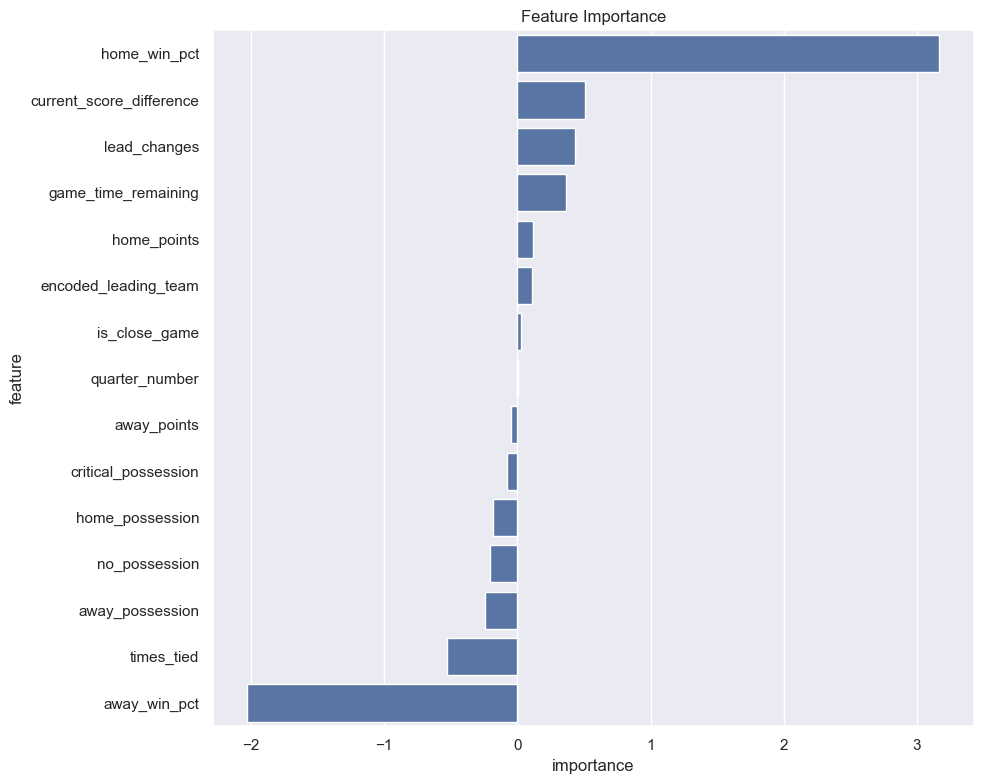

In [46]:
# Feature importance analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get feature importance from the model
feature_importance = pd.DataFrame(list(zip(X.columns, model.coef_[0])), columns=['feature', 'importance'])
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [47]:
# Implement GridSearchCV for hyperparameter tuning

from sklearn.model_selection import GridSearchCV

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(model, hyperparameters, cv=5)

# Fit grid search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04


 This problem is unconstrained.



At iterate   50    f=  1.91376D+05    |proj g|=  5.36498D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91369D+05    |proj g|=  1.14509D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   1.145D+02   1.914D+05
  F =   191369.39931846547     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91446D+05    |proj g|=  1.89344D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91438D+05    |proj g|=  6.17165D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   6.172D+01   1.914D+05
  F =   191438.31622033610     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91435D+05    |proj g|=  1.26860D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91432D+05    |proj g|=  2.26262D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   2.263D+01   1.914D+05
  F =   191431.63586618222     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91325D+05    |proj g|=  2.03764D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91322D+05    |proj g|=  2.57750D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   2.578D+02   1.913D+05
  F =   191322.18332578498     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91567D+05    |proj g|=  1.16066D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



At iterate  100    f=  1.91563D+05    |proj g|=  1.11562D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   1.116D+01   1.916D+05
  F =   191563.15034616608     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04

At iterate   50    f=  1.91372D+05    |proj g|=  7.60418D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91366D+05    |proj g|=  1.02297D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    105      1     0     0   1.023D+02   1.914D+05
  F =   191365.69214376583     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91442D+05    |proj g|=  2.61002D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91431D+05    |proj g|=  1.94372D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   1.944D+02   1.914D+05
  F =   191431.04493582746     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91431D+05    |proj g|=  2.18004D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91423D+05    |proj g|=  8.54628D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   8.546D+01   1.914D+05
  F =   191423.25260183969     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91321D+05    |proj g|=  1.82175D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91315D+05    |proj g|=  2.81186D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    107      1     0     0   2.812D+02   1.913D+05
  F =   191314.51970077693     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91562D+05    |proj g|=  1.35787D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



At iterate  100    f=  1.91558D+05    |proj g|=  2.11877D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    107      1     0     0   2.119D+01   1.916D+05
  F =   191558.18087533911     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04

At iterate   50    f=  1.91371D+05    |proj g|=  1.22383D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91365D+05    |proj g|=  1.43903D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    105      1     0     0   1.439D+02   1.914D+05
  F =   191365.01541166575     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91440D+05    |proj g|=  1.24004D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91431D+05    |proj g|=  5.69643D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   5.696D+01   1.914D+05
  F =   191431.15168680807     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91430D+05    |proj g|=  1.79688D+02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   50    f=  1.91323D+05    |proj g|=  4.95454D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91316D+05    |proj g|=  9.45615D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   9.456D+01   1.913D+05
  F =   191316.41499602512     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91562D+05    |proj g|=  1.21194D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



At iterate  100    f=  1.91552D+05    |proj g|=  2.35077D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    112      1     0     0   2.351D+02   1.916D+05
  F =   191552.36558263551     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04

At iterate   50    f=  1.91370D+05    |proj g|=  4.64910D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91366D+05    |proj g|=  8.84535D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   8.845D+01   1.914D+05
  F =   191366.33021711113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91441D+05    |proj g|=  2.21656D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91436D+05    |proj g|=  7.55104D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   7.551D+01   1.914D+05
  F =   191436.10585670345     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91428D+05    |proj g|=  1.41746D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91418D+05    |proj g|=  2.52734D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   2.527D+01   1.914D+05
  F =   191418.09843549444     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91322D+05    |proj g|=  8.56843D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91312D+05    |proj g|=  5.81304D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    114      1     0     0   5.813D+01   1.913D+05
  F =   191311.61801665291     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91559D+05    |proj g|=  9.13646D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



At iterate  100    f=  1.91555D+05    |proj g|=  4.28762D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   4.288D+01   1.916D+05
  F =   191555.36979710541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04

At iterate   50    f=  1.91370D+05    |proj g|=  6.16398D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91364D+05    |proj g|=  6.31981D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   6.320D+01   1.914D+05
  F =   191363.51474645143     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91437D+05    |proj g|=  1.34235D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91435D+05    |proj g|=  6.07395D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   6.074D+01   1.914D+05
  F =   191435.28759750602     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91427D+05    |proj g|=  2.70903D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91420D+05    |proj g|=  8.51749D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   8.517D+01   1.914D+05
  F =   191420.34277743194     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91321D+05    |proj g|=  5.17766D+02

At iterate  100    f=  1.91310D+05    |proj g|=  5.41640D+01

       

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  1.91560D+05    |proj g|=  1.14238D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



At iterate  100    f=  1.91549D+05    |proj g|=  2.52969D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   2.530D+02   1.915D+05
  F =   191549.01455034420     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04


 This problem is unconstrained.



At iterate   50    f=  1.91370D+05    |proj g|=  5.94604D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91364D+05    |proj g|=  2.40777D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    106      1     0     0   2.408D+02   1.914D+05
  F =   191364.17680328697     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91437D+05    |proj g|=  2.07601D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91434D+05    |proj g|=  9.09024D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    105      1     0     0   9.090D+01   1.914D+05
  F =   191433.80136228120     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91427D+05    |proj g|=  4.47375D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91424D+05    |proj g|=  2.40201D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   2.402D+02   1.914D+05
  F =   191423.80645553005     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91321D+05    |proj g|=  3.42253D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91312D+05    |proj g|=  6.58518D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   6.585D+01   1.913D+05
  F =   191312.19208778106     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91559D+05    |proj g|=  1.04297D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91555D+05    |proj g|=  2.71930D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   2.719D+01   1.916D+05
  F =   191555.13568162679     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04

At iterate   50    f=  1.91370D+05    |proj g|=  5.62645D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91360D+05    |proj g|=  5.80089D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    107      1     0     0   5.801D+01   1.914D+05
  F =   191360.26380174639     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91438D+05    |proj g|=  1.28180D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91425D+05    |proj g|=  6.46666D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   6.467D+01   1.914D+05
  F =   191424.93556602631     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91428D+05    |proj g|=  3.63143D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91424D+05    |proj g|=  2.38252D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   2.383D+01   1.914D+05
  F =   191424.21560055434     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91321D+05    |proj g|=  2.95709D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91315D+05    |proj g|=  2.55801D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   2.558D+01   1.913D+05
  F =   191315.14043347747     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91560D+05    |proj g|=  1.26025D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



At iterate  100    f=  1.91549D+05    |proj g|=  6.87951D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    109      1     0     0   6.880D+01   1.915D+05
  F =   191549.40796847577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04


 This problem is unconstrained.



At iterate   50    f=  1.91370D+05    |proj g|=  5.43091D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91367D+05    |proj g|=  2.38775D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    107      1     0     0   2.388D+02   1.914D+05
  F =   191366.69721049356     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91438D+05    |proj g|=  1.13957D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91436D+05    |proj g|=  6.35362D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    105      1     0     0   6.354D+01   1.914D+05
  F =   191435.81620093551     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91428D+05    |proj g|=  3.63214D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91424D+05    |proj g|=  5.92473D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    106      1     0     0   5.925D+01   1.914D+05
  F =   191424.30778752896     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91321D+05    |proj g|=  2.80925D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91315D+05    |proj g|=  2.79164D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   2.792D+01   1.913D+05
  F =   191314.92939019669     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91560D+05    |proj g|=  1.26750D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



At iterate  100    f=  1.91547D+05    |proj g|=  2.19269D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   2.193D+02   1.915D+05
  F =   191547.22480325474     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04


 This problem is unconstrained.



At iterate   50    f=  1.91370D+05    |proj g|=  5.34919D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91366D+05    |proj g|=  5.36164D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    107      1     0     0   5.362D+01   1.914D+05
  F =   191366.08981107600     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91439D+05    |proj g|=  4.75994D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91430D+05    |proj g|=  1.42084D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    107      1     0     0   1.421D+02   1.914D+05
  F =   191430.09406946969     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91428D+05    |proj g|=  3.63878D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91424D+05    |proj g|=  2.67750D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    108      1     0     0   2.677D+01   1.914D+05
  F =   191423.94182440423     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91321D+05    |proj g|=  2.75848D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91315D+05    |proj g|=  5.44111D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    112      1     0     0   5.441D+01   1.913D+05
  F =   191315.35483828731     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91560D+05    |proj g|=  1.17627D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



At iterate  100    f=  1.91555D+05    |proj g|=  1.26092D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    113      1     0     0   1.261D+02   1.916D+05
  F =   191554.73083737417     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.83018D+04


 This problem is unconstrained.



At iterate   50    f=  1.91370D+05    |proj g|=  5.31854D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91359D+05    |proj g|=  4.26745D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    106      1     0     0   4.267D+02   1.914D+05
  F =   191358.52856946093     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81275D+04

At iterate   50    f=  1.91438D+05    |proj g|=  8.69305D+01


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91436D+05    |proj g|=  5.77576D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    106      1     0     0   5.776D+01   1.914D+05
  F =   191435.51632808795     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81037D+04

At iterate   50    f=  1.91428D+05    |proj g|=  3.64244D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91424D+05    |proj g|=  6.31708D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    107      1     0     0   6.317D+01   1.914D+05
  F =   191423.59446382470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.82379D+04

At iterate   50    f=  1.91321D+05    |proj g|=  2.74054D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  1.91313D+05    |proj g|=  1.19726D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    110      1     0     0   1.197D+02   1.913D+05
  F =   191313.22976525483     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16345D+05    |proj g|=  4.81414D+04

At iterate   50    f=  1.91560D+05    |proj g|=  1.12082D+02


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:



At iterate  100    f=  1.91557D+05    |proj g|=  2.32999D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    112      1     0     0   2.330D+01   1.916D+05
  F =   191556.68185097713     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70431D+05    |proj g|=  6.02281D+04

At iterate   50    f=  2.39279D+05    |proj g|=  2.10046D+02

At iterate  100    f=  2.39275D+05    |proj g|=  7.04026D+01

       

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# Implement AdaBoost

from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=500, random_state=42, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validated scores:", scores)


Accuracy: 0.7096003608849885
              precision    recall  f1-score   support

       False       0.69      0.56      0.62     40824
        True       0.72      0.82      0.77     56714

    accuracy                           0.71     97538
   macro avg       0.70      0.69      0.69     97538
weighted avg       0.71      0.71      0.70     97538

Cross-validated scores: [0.58461318 0.61333019 0.58838606 0.59993643 0.41866164]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


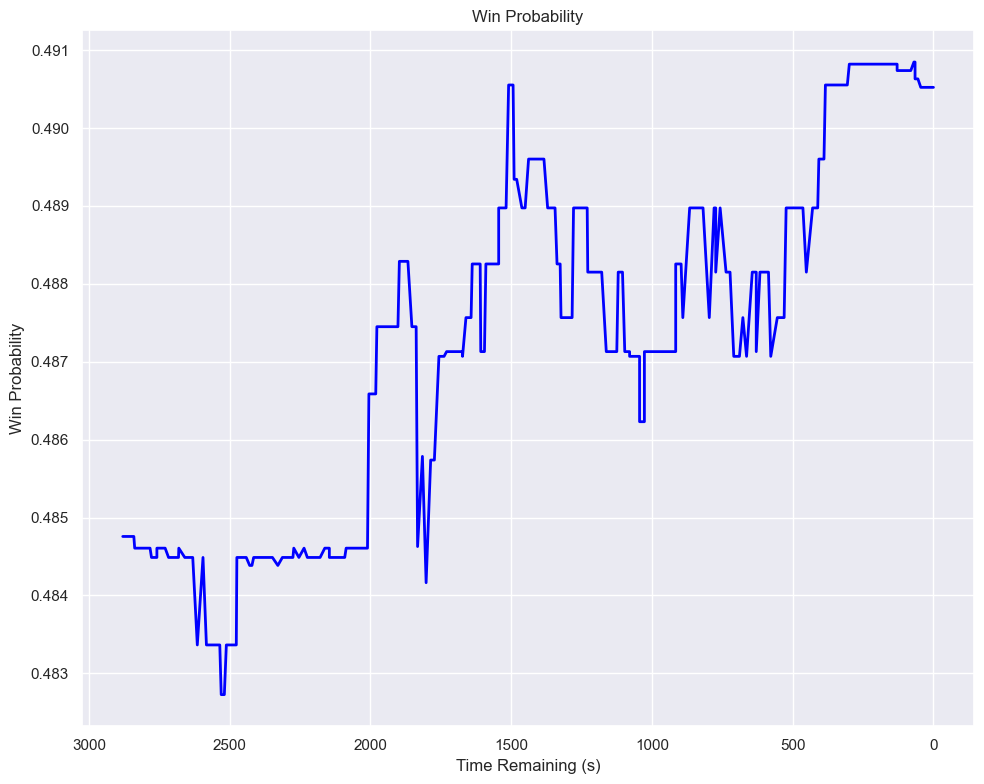

home_points                -0.738489
away_points                -0.640317
quarter_number                     2
game_time_remaining         0.698108
current_score_difference   -0.990841
                              ...   
target                          True
home_possession                    1
away_possession                    0
no_possession                      0
encoded_leading_team               0
Name: 119, Length: 16, dtype: object


In [62]:
# Get data from a json file, preprocess it and use the trained model to predict probabilities for each event

def predict_probabilities(df):
    df_processed = process_data(df)
    df_processed.head()
    period_data = extract_periods(df_processed)
    event_data = extract_events(period_data)
    event_data.dropna(inplace=True)
    return event_data

# Open the file
with open("data/celmag171223.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Get the probabilities for each event
event_data = predict_probabilities(df)

X = event_data.drop(['target'], axis=1)  # Features
y = event_data['target']            # Target variable
win_probabilities = model.predict_proba(X)

win_probabilities = win_probabilities[:, 0]  # Adjust based on your class of interest

# Plot the win probabilities where x is the seconds remaining in the game and y is the win probability for the home team
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10, 8))
plt.plot(event_data['game_time_remaining'] * 2880, win_probabilities, color='blue', linewidth=2)
plt.title('Win Probability')
plt.xlabel('Time Remaining (s)')
plt.ylabel('Win Probability')
plt.gca().invert_xaxis()  # Reverse the x-axis
plt.tight_layout()
plt.show()

# Calculate the differences between consecutive win probabilities
diffs = np.diff(win_probabilities)

# Find the index of the largest jump
largest_jump_index = np.argmax(diffs)

# Get the event that caused the largest jump
event = event_data.iloc[largest_jump_index]

print(event)


In [ ]:
# Create a time series for the x-axis (assuming each event is one unit of time)
time_series = range(len(event_data))

# Plot the win probabilities over time
plt.plot(time_series, event_data)
plt.xlabel('Time')
plt.ylabel('Win Probability')
plt.title('Win Probability Over Time')
plt.show()

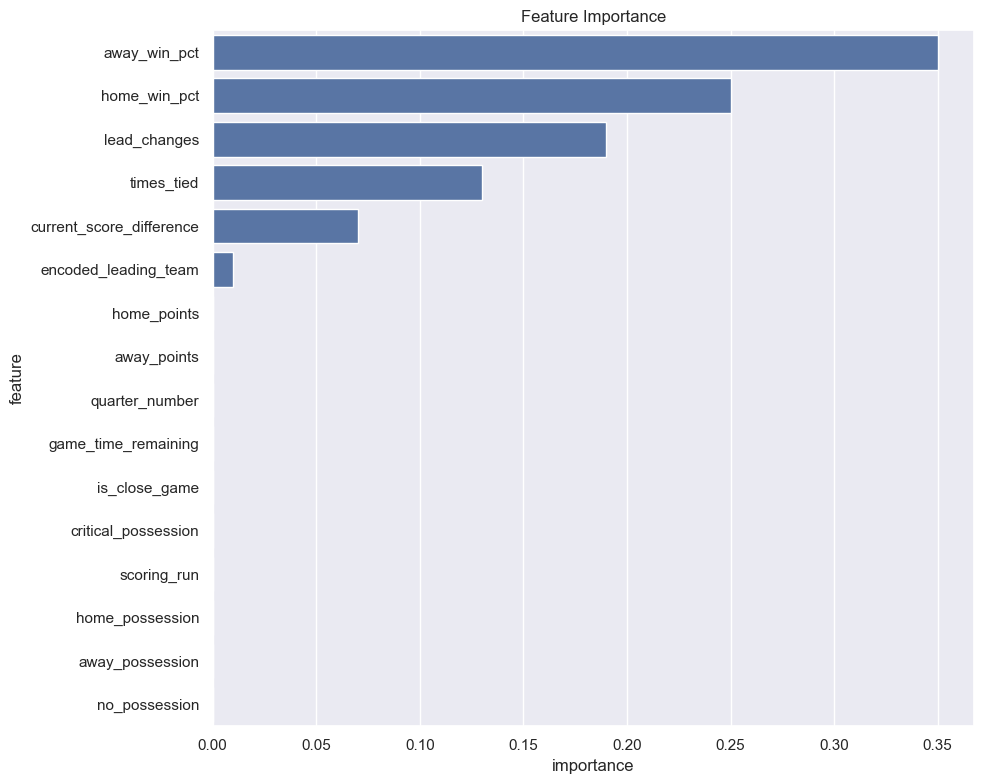

In [ ]:
# Feature importance analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get feature importance from the model
feature_importance = pd.DataFrame(list(zip(X.columns, model.feature_importances_)), columns=['feature', 'importance'])
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Implement GridSearchCV for AdaBoost

from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [200,500, 750], 'learning_rate': [0.01, 0.1, 1.0]}
model = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_estimator_.feature_importances_)

y_pred = grid_search.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5)
print("Cross-validated scores:", scores)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'n_estimators': 500}
0.7659464308599258
AdaBoostClassifier(n_estimators=500, random_state=42)
[0.004 0.008 0.    0.    0.026 0.    0.    0.254 0.152 0.    0.21  0.342
 0.    0.    0.    0.004]
Accuracy: 0.7639996719227378
              precision    recall  f1-score   support

       False       0.75      0.65      0.70     40824
        True       0.77      0.85      0.81     56714

    accuracy                           0.76     97538
   macro avg       0.76      0.75      0.75     97538
weighted avg       0.76      0.76      0.76     97538

Cross-validated scores: [0.60221657 0.4855441  0.39377473 0.43131325 0.42122477]


In [ ]:
# Implement XGBoost

from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validated scores:", scores)

Accuracy: 0.9995386413500379
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     40824
        True       1.00      1.00      1.00     56714

    accuracy                           1.00     97538
   macro avg       1.00      1.00      1.00     97538
weighted avg       1.00      1.00      1.00     97538

Cross-validated scores: [0.60746581 0.57713917 0.48044865 0.53455612 0.42137855]


In [ ]:
# Implement GridSearchCV for XGBoost

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Best estimator:", grid_search.best_estimator_)
print("Test score:", grid_search.score(X_test, y_test))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 5, 'n_estimators': 300}
Best cross-validation score: 1.0
Best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Test score: 1.0


In [ ]:
def hello():
    print("hello")

In [ ]:
# Get data from a json file, preprocess it and use the trained model to predict probabilities for each event

def predict_probabilities(json_data):
    df = pd.json_normalize(json_data)
    df_processed = process_data(df)
    period_data = extract_periods(df_processed)
    event_data = extract_events(period_data)
    event_data.dropna(inplace=True)
    X = event_data.drop(['target'], axis=1)  # Features
    y = event_data['target']               # Target variable
    y_pred = grid_search.best_estimator_.predict_proba(X)
    return y_pred

# Open the file
with open("data/celmag171223.json", "r") as f:
    data = json.load(f)

# Get the probabilities for each event
event_data = predict_probabilities(data)

event_data = event_data[:, 1]  # Adjust based on your class of interest

# Plot the win probabilities
plt.figure(figsize=(10, 8))
plt.plot(event_data)
plt.title('Win Probability')
plt.xlabel('Event')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

In [ ]:
# Create a time series for the x-axis (assuming each event is one unit of time)
time_series = range(len(event_data))

# Plot the win probabilities over time
plt.plot(time_series, event_data)
plt.xlabel('Time')
plt.ylabel('Win Probability')
plt.title('Win Probability Over Time')
plt.show()